0 lines read
100 lines read
200 lines read
300 lines read
400 lines read
500 lines read
600 lines read
700 lines read
800 lines read
900 lines read
1000 lines read
1100 lines read
1200 lines read
1300 lines read
1400 lines read
1500 lines read
1600 lines read
1700 lines read
1800 lines read
1900 lines read
2000 lines read
2100 lines read
2200 lines read
2300 lines read
2400 lines read
2500 lines read
2600 lines read
2700 lines read
2800 lines read
2900 lines read
3000 lines read
3100 lines read
3200 lines read
3300 lines read
3400 lines read
3500 lines read
3600 lines read
3700 lines read
3800 lines read
3900 lines read
4000 lines read
4100 lines read
4200 lines read
4300 lines read
4400 lines read
4500 lines read
4600 lines read
4700 lines read
4800 lines read
4900 lines read
5000 lines read
5100 lines read
5200 lines read
5300 lines read
5400 lines read
5500 lines read
5600 lines read
5700 lines read
5800 lines read
5900 lines read
6000 lines read
6100 lines read
6200 lines read
6300

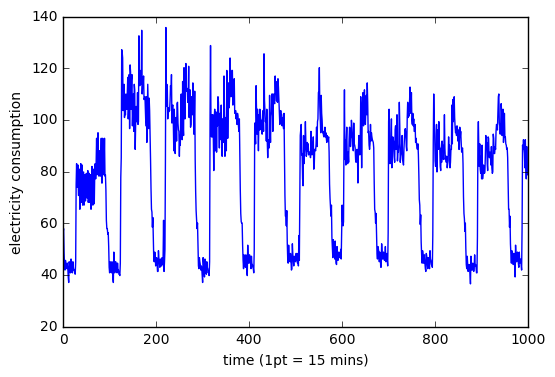

FileNotFoundError: [Errno 2] No such file or directory: '../data/LD_250.npy'

In [8]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import os
import re

DATA_DIR = "../data"

fld = open(os.path.join("LD2011_2014.txt"), "r")
data = []
line_num = 0
#cid = np.random.randint(0, 370, 1)
cid = 250
for line in fld:
    if line.startswith("\"\";"):
        continue
    if line_num % 100 == 0:
        print("{:d} lines read".format(line_num))
    cols = [float(re.sub(",", ".", x)) for x in 
            line.strip().split(";")[1:]]
    data.append(cols[cid])
    line_num += 1
fld.close()

NUM_ENTRIES = 1000
plt.plot(range(NUM_ENTRIES), data[0:NUM_ENTRIES])
plt.ylabel("electricity consumption")
plt.xlabel("time (1pt = 15 mins)")
plt.show()



In [9]:
np.save(os.path.join("LD_250.npy"), np.array(data))

In [10]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math
import os


Using TensorFlow backend.


In [11]:

DATA_DIR = "../data"

data = np.load(os.path.join("LD_250.npy"))

STATELESS = False

NUM_TIMESTEPS = 20
HIDDEN_SIZE = 10
BATCH_SIZE = 96  # 24 hours (15 min intervals)
NUM_EPOCHS = 5


In [16]:
# scale the data to be in the range (0, 1)
print(data.shape,data.reshape(-1, 1).shape)


(140256,) (140256, 1)


In [17]:
# scale the data to be in the range (0, 1)
data = data.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
data = scaler.fit_transform(data)

In [18]:
# transform to 4 inputs -> 1 label format
X = np.zeros((data.shape[0], NUM_TIMESTEPS))
Y = np.zeros((data.shape[0], 1))
for i in range(len(data) - NUM_TIMESTEPS - 1):
    X[i] = data[i:i + NUM_TIMESTEPS].T
    Y[i] = data[i + NUM_TIMESTEPS + 1]


In [19]:
X.shape

(140256, 20)

In [20]:
X

array([[0.37875314, 0.38970776, 0.32776504, ..., 0.309568  , 0.29137096,
        0.27677694],
       [0.38970776, 0.32776504, 0.29137096, ..., 0.29137096, 0.27677694,
        0.27313753],
       [0.32776504, 0.29137096, 0.28041635, ..., 0.27677694, 0.27313753,
        0.30228919],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [22]:
Y

array([[0.30228919],
       [0.28773156],
       [0.28041635],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

In [23]:
# reshape X to three dimensions (samples, timesteps, features)
X = np.expand_dims(X, axis=2)


In [24]:
X

array([[[0.37875314],
        [0.38970776],
        [0.32776504],
        ...,
        [0.309568  ],
        [0.29137096],
        [0.27677694]],

       [[0.38970776],
        [0.32776504],
        [0.29137096],
        ...,
        [0.29137096],
        [0.27677694],
        [0.27313753]],

       [[0.32776504],
        [0.29137096],
        [0.28041635],
        ...,
        [0.27677694],
        [0.27313753],
        [0.30228919]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

In [25]:
X.shape

(140256, 20, 1)

In [26]:
# split into training and test sets (add the extra offsets so 
# we can use batch size of 5)
sp = int(0.7 * len(data))
Xtrain, Xtest, Ytrain, Ytest = X[0:sp], X[sp:], Y[0:sp], Y[sp:]
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(98179, 20, 1) (42077, 20, 1) (98179, 1) (42077, 1)


In [27]:
if STATELESS:
    # stateless
    model = Sequential()
    model.add(LSTM(HIDDEN_SIZE, input_shape=(NUM_TIMESTEPS, 1), 
                   return_sequences=False))
    model.add(Dense(1))
else:
    # stateful
    model = Sequential()
    model.add(LSTM(HIDDEN_SIZE, stateful=True,
                   batch_input_shape=(BATCH_SIZE, NUM_TIMESTEPS, 1), 
                   return_sequences=False))
    model.add(Dense(1))

model.compile(loss="mean_squared_error", optimizer="adam",
              metrics=["mean_squared_error"])


In [28]:
if STATELESS:
    # stateless
    model.fit(Xtrain, Ytrain, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
              validation_data=(Xtest, Ytest),
              shuffle=False)
else:
    # stateful
    # need to make training and test data to multiple of BATCH_SIZE
    train_size = (Xtrain.shape[0] // BATCH_SIZE) * BATCH_SIZE
    test_size = (Xtest.shape[0] // BATCH_SIZE) * BATCH_SIZE
    Xtrain, Ytrain = Xtrain[0:train_size], Ytrain[0:train_size]
    Xtest, Ytest = Xtest[0:test_size], Ytest[0:test_size]
    print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)


(98112, 20, 1) (42048, 20, 1) (98112, 1) (42048, 1)


In [29]:
    for i in range(NUM_EPOCHS):
        print("Epoch {:d}/{:d}".format(i+1, NUM_EPOCHS))
        model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE, epochs=1,
                  validation_data=(Xtest, Ytest),
                  shuffle=False)
        model.reset_states()


Epoch 1/5
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 13s 132us/step - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 2/5
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 17s 173us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 3/5
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 16s 166us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 4/5
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 13s 137us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/5
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [=====

In [30]:
score, _ = model.evaluate(Xtest, Ytest, batch_size=BATCH_SIZE)
rmse = math.sqrt(score)
print("\nMSE: {:.3f}, RMSE: {:.3f}".format(score, rmse))

42048/42048 [==============================] - 2s 38us/step

MSE: 0.004, RMSE: 0.061
